<a href="https://colab.research.google.com/github/albert-yue/gcn-explainability/blob/master/notebooks/experiment_ohsumed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
%cd gdrive/My\ Drive/MIT/gcn_explainability/

[Errno 2] No such file or directory: 'gdrive/My Drive/MIT/gcn_explainability/'
/content/gdrive/My Drive/MIT/gcn_explainability


In [0]:
!git pull

^C


# Set up Vocabulary and Labels

In [0]:
from src.data import save_all_labels

save_all_labels('data/ohsumed-labels.txt', 'data/train-ohsumed.txt', 'data/test-ohsumed.txt')

In [0]:
from src.data import save_vocabulary

save_vocabulary('data/ohsumed-vocabulary.txt', 'data/train-ohsumed.txt', 'data/test-ohsumed.txt')

# Training

In [0]:
from src.data import Corpus, get_data, get_vocabulary, get_labels
from src.models.gcn import GCN
from src.preprocessing import clean_text, build_adj_matrix, normalize_adj
from src.train import train, evaluate, accuracy

In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
from matplotlib import pyplot as plt

def plot_loss(train_losses, val_losses):
    plt.title("Ohsumed Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.legend(loc='lower left')

In [0]:
seed = 0
val_split = 0.1

vocab = get_vocabulary('data/ohsumed-vocabulary.txt')
labels = get_labels('data/ohsumed-labels.txt')
corpus = get_data('data/train-ohsumed.txt', labels)
test_corpus = get_data('data/test-ohsumed.txt', labels)

# Split validation set
corpus.shuffle(seed)
len_train = int(len(corpus) * (1 - val_split))
train_corpus = Corpus(corpus[:len_train])
val_corpus = Corpus(corpus[len_train:])

num_documents = len(train_corpus) + len(val_corpus) + len(test_corpus)

In [0]:
# Mask out unknown words
clean_text(corpus, vocab)
clean_text(test_corpus, vocab)

## Separate Matrices

In [0]:
train_adj_matrix = build_adj_matrix(train_corpus, vocab, num_documents, doc_offset=0)
val_adj_matrix = build_adj_matrix(val_corpus, vocab, num_documents, doc_offset=len(train_corpus))
test_adj_matrix = build_adj_matrix(test_corpus, vocab, num_documents, doc_offset=len(train_corpus) + len(val_corpus))

In [0]:
from src.utils import save_sparse_tensor

save_sparse_tensor(train_adj_matrix, 'data/ohsumed_train_adj_matrix.pt')
save_sparse_tensor(val_adj_matrix, 'data/ohsumed_val_adj_matrix.pt')
save_sparse_tensor(test_adj_matrix, 'data/ohsumed_test_adj_matrix.pt')

In [0]:
from src.utils import load_sparse_tensor

train_adj_matrix = load_sparse_tensor('data/ohsumed_train_adj_matrix.pt')
val_adj_matrix = load_sparse_tensor('data/ohsumed_val_adj_matrix.pt')
test_adj_matrix = load_sparse_tensor('data/ohsumed_test_adj_matrix.pt')

In [0]:
train_adj_matrix = normalize_adj(train_adj_matrix)
val_adj_matrix = normalize_adj(val_adj_matrix)
test_adj_matrix = normalize_adj(test_adj_matrix)

In [0]:
hidden_size = 200  # hyperparameter
dropout = 0.5  # hyperparameter
epochs = 700
lr = 0.02

num_vertices = len(vocab) + num_documents
model = GCN(num_vertices, hidden_size, len(labels), dropout=dropout)

In [0]:
%time train_losses, val_losses = train(model, train_adj_matrix, val_adj_matrix, train_corpus.labels(), val_corpus.labels(), len(vocab), epochs=epochs, init_lr=lr, plot_every=5, print_every=10, save_path='ohsumed_train.pt')

Epoch 0
Train mean cross-entropy: 3.9511983394622803
Validation mean cross-entropy: 3.883282423019409
Epoch 10
Train mean cross-entropy: 2.222351312637329
Validation mean cross-entropy: 2.7319843769073486
Epoch 20
Train mean cross-entropy: 1.5813546180725098
Validation mean cross-entropy: 2.29337739944458
Epoch 30
Train mean cross-entropy: 1.2049384117126465
Validation mean cross-entropy: 1.9220281839370728
Epoch 40
Train mean cross-entropy: 0.9469305872917175
Validation mean cross-entropy: 1.8204712867736816
Epoch 50
Train mean cross-entropy: 0.7099745869636536
Validation mean cross-entropy: 1.6470983028411865
Epoch 60
Train mean cross-entropy: 0.5300287008285522
Validation mean cross-entropy: 1.6049593687057495
Epoch 70
Train mean cross-entropy: 0.3941210210323334
Validation mean cross-entropy: 1.5657336711883545
Epoch 80
Train mean cross-entropy: 0.29735371470451355
Validation mean cross-entropy: 1.621703863143921
CPU times: user 1min 39s, sys: 703 ms, total: 1min 40s
Wall time: 1mi

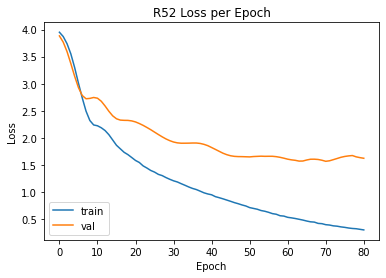

In [0]:
plot_loss(train_losses, val_losses)

In [0]:
test_start_idx = len(vocab) + len(train_corpus) + len(val_corpus)
test_loss = evaluate(model, test_adj_matrix, test_corpus.labels(), accuracy, start_idx=test_start_idx)
print(test_loss)

0.544392523364486


## Full Matrix

In [0]:
full_corpus = Corpus(train_corpus.data + val_corpus.data + test_corpus.data)

In [0]:
%time adj_matrix = build_adj_matrix(full_corpus, vocab, num_documents, doc_offset=0)

Building word frequencies per doc



Building word frequencies per window



Calculating PMIs



Calculating TF-IDF



Identities



CPU times: user 8min 27s, sys: 5.11 s, total: 8min 33s
Wall time: 8min 32s


In [0]:
from src.utils import save_sparse_tensor

save_sparse_tensor(adj_matrix, 'data/ohsumed_full_adj_matrix.pt')

In [0]:
from src.utils import load_sparse_tensor

adj_matrix = load_sparse_tensor('data/ohsumed_full_adj_matrix.pt')

In [0]:
adj_matrix = normalize_adj(adj_matrix)

In [0]:
hidden_size = 200  # hyperparameter
dropout = 0.5  # hyperparameter
epochs = 700
lr = 0.02

num_vertices = len(vocab) + num_documents
model = GCN(num_vertices, hidden_size, len(labels), dropout=dropout)

In [0]:
%time train_losses, val_losses = train(model, adj_matrix, adj_matrix, train_corpus.labels(), val_corpus.labels(), len(vocab), epochs=epochs, init_lr=lr, plot_every=5, print_every=10, save_path='gcn_ohsumed_full.pt')

Epoch 0
Train mean cross-entropy: 3.1353559494018555
Validation mean cross-entropy: 3.0938925743103027
Epoch 10
Train mean cross-entropy: 2.7301087379455566
Validation mean cross-entropy: 2.6867003440856934
Epoch 20
Train mean cross-entropy: 2.443741798400879
Validation mean cross-entropy: 2.4357903003692627
Epoch 30
Train mean cross-entropy: 2.0931313037872314
Validation mean cross-entropy: 2.1653189659118652
Epoch 40
Train mean cross-entropy: 1.790251612663269
Validation mean cross-entropy: 1.997796893119812
Epoch 50
Train mean cross-entropy: 1.5408799648284912
Validation mean cross-entropy: 1.9271470308303833
Epoch 60
Train mean cross-entropy: 1.3355234861373901
Validation mean cross-entropy: 1.93824303150177
CPU times: user 9min 36s, sys: 2.7 s, total: 9min 39s
Wall time: 9min 44s


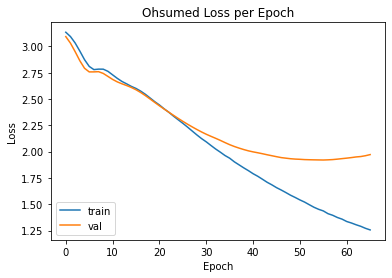

In [0]:
plot_loss(train_losses, val_losses)

In [0]:
test_start_idx = len(vocab) + len(train_corpus) + len(val_corpus)
test_acc = evaluate(model, adj_matrix, test_corpus.labels(), accuracy, start_idx=test_start_idx)
print(test_acc)

0.42739338726144666


In [0]:
print(train_losses)
print(val_losses)

[3.1353559494018555, 3.094197988510132, 3.0330440998077393, 2.956211566925049, 2.8746800422668457, 2.8105311393737793, 2.7800955772399902, 2.7845892906188965, 2.7841885089874268, 2.7637081146240234, 2.7301087379455566, 2.696761131286621, 2.6673152446746826, 2.6444194316864014, 2.6204681396484375, 2.600886821746826, 2.5752673149108887, 2.545084238052368, 2.5103204250335693, 2.474991798400879, 2.443741798400879, 2.407362937927246, 2.3744263648986816, 2.3376097679138184, 2.3032026290893555, 2.2692410945892334, 2.2333929538726807, 2.195960760116577, 2.158804178237915, 2.12383770942688, 2.0931313037872314, 2.0586819648742676, 2.0251662731170654, 1.9950190782546997, 1.9631119966506958, 1.937574863433838, 1.9030004739761353, 1.8744826316833496, 1.845905065536499, 1.8192172050476074, 1.790251612663269, 1.7657129764556885, 1.7375211715698242, 1.7086788415908813, 1.6845343112945557, 1.6577563285827637, 1.6351897716522217, 1.610926628112793, 1.585681676864624, 1.564039945602417, 1.540879964828491

In [0]:
import numpy as np

repeats = 10
repeats_test_acc = []
for i in range(repeats):
    model = GCN(num_vertices, hidden_size, len(labels), dropout=dropout)
    train(model, adj_matrix, adj_matrix, train_corpus.labels(), val_corpus.labels(), len(vocab), epochs=epochs, init_lr=lr, plot_every=5, print_every=10, save_path='gcn_ohsumed_full_repeats.pt')
    test_acc = evaluate(model, adj_matrix, test_corpus.labels(), accuracy, start_idx=test_start_idx)
    repeats_test_acc.append(test_acc)

repeats_test_acc = np.array(repeats_test_acc)
print('Mean %s and std %s' % (np.mean(repeats_test_acc), np.std(repeats_test_acc)))